Import Pakete

In [ ]:
!pip install opencv-python

In [ ]:
import shutil
import os
import zipfile
import csv
from collections import defaultdict
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random

Mounten des eigenen Drives. Falls Dateien direkt aus Github verwendet werden, muss der entsprechende Raw-Link verwendet werden.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Hilfsfunktionen

##Download eines kompletten Ordners aus /content

In [ ]:
def download_folder(folder_path, output_filename):
  """
  Komprimiert einen Ordner und lädt ihn herunter.

  Args:
    folder_path: Der Pfad zum Ordner, der heruntergeladen werden soll.
    output_filename: Der Name der komprimierten Datei.
  """

  with zipfile.ZipFile(output_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(folder_path):
      for file in files:
        file_path = os.path.join(root, file)
        zipf.write(file_path, os.path.relpath(file_path, folder_path))

  from google.colab import files
  files.download(output_filename)

# Beispielaufruf:
folder_path = "/content/UnicodeGlyphs" # Pfad zum Ordner, der heruntergeladen werden soll
output_filename = "UnicodeGlyphs.zip" # Name der komprimierten Datei
download_folder(folder_path, output_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Funktion zum Löschen ganzer Ordner in /content

In [ ]:
def delete_folder(folder_path):
    """Löscht einen Ordner, falls er existiert.

    Args:
        folder_path: Der Pfad zum Ordner, der gelöscht werden soll.
    """

    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Ordner '{folder_path}' gelöscht.")
    else:
        print(f"Ordner '{folder_path}' existiert nicht.")

In [ ]:
delete_folder('/content/Datensatz_Final')

Ordner '/content/Datensatz_Final' gelöscht.


##Funktion zum Erstellen von Ordnern

In [ ]:
def erstelle_ordner(ordner_pfad):
    """Erstellt einen Ordner, falls dieser noch nicht existiert.

    Args:
        ordner_pfad: Der Pfad zum Ordner, der erstellt werden soll.
    """
    if not os.path.exists(ordner_pfad):
        os.makedirs(ordner_pfad)
        print(f"Ordner '{ordner_pfad}' erstellt.")
    else:
        print(f"Ordner '{ordner_pfad}' existiert bereits.")

# Vorbereitung Datensatz

Erstellung der Klassenliste

In [ ]:
# Gardinerliste aus CSV-Datei laden
gardiner_list = []
with open('/content/drive/MyDrive/Mathestudium/Data Science MSc/Masterarbeit/Datensätze/unicode_gardinercodes_kurz.csv', 'r', encoding='utf-8') as file:
    reader = csv.reader(file, delimiter=';')
    next(reader)  # Überspringe die Kopfzeile
    for row in reader:
        gardiner_id = int(row[0])  # Gardiner ID aus der ersten Spalte
        gardiner_value = row[2]  # Gardiner Wert aus der zweiten Spalte
        gardiner_list.append((gardiner_id, gardiner_value))  # Füge das Tupel zur Liste hinzu

print(gardiner_list)

# Erstelle ein Dictionary zur Zuordnung von gardiner_value zu gardiner_id
gardiner_dict = {gardiner_value: gardiner_id for gardiner_id, gardiner_value in gardiner_list}

# Extrahiere die gardiner_values in eine separate Liste
gardiner_values_list = [value for _, value in gardiner_list]

print(gardiner_values_list)

[(1, 'A1'), (2, 'A2'), (3, 'A3'), (4, 'A4'), (5, 'A5'), (6, 'A5a'), (7, 'A6'), (8, 'A6a'), (9, 'A6b'), (10, 'A7'), (11, 'A8'), (12, 'A9'), (13, 'A10'), (14, 'A11'), (15, 'A12'), (16, 'A13'), (17, 'A14'), (18, 'A14a'), (19, 'A15'), (20, 'A16'), (21, 'A17'), (22, 'A17a'), (23, 'A18'), (24, 'A19'), (25, 'A20'), (26, 'A21'), (27, 'A22'), (28, 'A23'), (29, 'A24'), (30, 'A25'), (31, 'A26'), (32, 'A27'), (33, 'A28'), (34, 'A29'), (35, 'A30'), (36, 'A31'), (37, 'A32'), (38, 'A32a'), (39, 'A33'), (40, 'A34'), (41, 'A35'), (42, 'A36'), (43, 'A37'), (44, 'A38'), (45, 'A39'), (46, 'A40'), (47, 'A40a'), (48, 'A41'), (49, 'A42'), (50, 'A42a'), (51, 'A43'), (52, 'A43a'), (53, 'A44'), (54, 'A45'), (55, 'A45a'), (56, 'A46'), (57, 'A47'), (58, 'A48'), (59, 'A49'), (60, 'A50'), (61, 'A51'), (62, 'A52'), (63, 'A53'), (64, 'A54'), (65, 'A55'), (66, 'A56'), (67, 'A57'), (68, 'A58'), (69, 'A59'), (70, 'A60'), (71, 'A61'), (72, 'A62'), (73, 'A63'), (74, 'A64'), (75, 'A65'), (76, 'A66'), (77, 'A67'), (78, 'A68

Font-Datensatz

In [ ]:
# Überprüfen, ob der Zielordner bereits existiert und ihn gegebenenfalls löschen
if os.path.exists('/content/Datensatz_Klassifikator'):
    shutil.rmtree('/content/Datensatz_Klassifikator')

# Den Ordner kopieren
shutil.copytree('/content/drive/MyDrive/Datensatz_Klassifikator', '/content/Datensatz_Klassifikator')

print("Ordner kopiert!")

#Dauert lange (19 min). Nächstes mal zip hochladen und dann entpacken.

Ordner kopiert!


In [ ]:
def konsolidiere(quellordner, zielordner, gardiner_values_list):
  """Konsolidiert alle Elemente aus Unterordnern in einen gemeinsamen Ordner,
  filtert nach gardiner_values_list.

  Args:
    quellordner: Der Pfad zum Quellordner mit den Unterordnern.
    zielordner: Der Name des Zielordners, der erstellt wird.
    gardiner_values_list: Die Liste der gültigen Gardiner-Werte.
  """

  # Zielordner erstellen, falls er nicht existiert
  if not os.path.exists(zielordner):
    os.makedirs(zielordner)

  # Durch alle Unterordner iterieren
  for unterordner_pfad, _, dateinamen in os.walk(quellordner):
    for dateiname in dateinamen:
      # Nur Bilddateien verarbeiten
      if dateiname.endswith(('.png', '.jpg', '.jpeg', '.gif')):
        # Dateinamen an "_" splitten und erstes Element extrahieren
        erstes_element = dateiname.split('_')[0]
        drittes_element = dateiname.split('_')[2]

        # Überprüfen, ob das erste Element in gardiner_values_list vorkommt
        if erstes_element in gardiner_values_list:
          quell_pfad = os.path.join(unterordner_pfad, dateiname)
          ziel_pfad = os.path.join(zielordner, dateiname)

          # Datei in den Zielordner kopieren (mit Konfliktbehandlung)
          i = 1
          while os.path.exists(os.path.join(zielordner, f"{erstes_element}_font_{drittes_element}_{i}{'.png'}")):
            i += 1
          shutil.copy(quell_pfad, os.path.join(zielordner, f"{erstes_element}_font_{drittes_element}_{i}{'.png'}"))


# Beispielaufruf
quellordner = '/content/Datensatz_Klassifikator'
zielordner = '/content/Datensatz_Fonts'
konsolidiere(quellordner, zielordner, gardiner_values_list)

In [ ]:
def zaehle_bilder_in_ordnern(ordner_pfade):
    """Zählt Bilder in verschiedenen Ordnern und gibt die Ergebnisse in einem DataFrame zurück.

    Args:
        ordner_pfade: Eine Liste von Pfaden zu den Ordnern, die gezählt werden sollen.

    Returns:
        Ein pandas DataFrame mit den Klassenlabels als Index und den Ordnernamen als Spalten.
    """

    anzahl_bilder_pro_klasse = defaultdict(lambda: defaultdict(int))

    for ordner_pfad in ordner_pfade:
        ordner_name = os.path.basename(ordner_pfad)  # Name des aktuellen Ordners

        for dateiname in os.listdir(ordner_pfad):
            if dateiname.endswith(('.png', '.PNG', '.jpg', '.jpeg')):
                klassenlabel = dateiname.split('_')[0]
                anzahl_bilder_pro_klasse[klassenlabel][ordner_name] += 1

    # DataFrame erstellen
    df = pd.DataFrame(anzahl_bilder_pro_klasse).T.fillna(0).astype(int)
    df.index.name = 'Klassenlabel'

    # Klassenlabels als erste Spalte setzen
    df = df.reset_index()

    return df

# Beispielaufruf
ordner_pfade = ['/content/Datensatz_Fonts', '/content/Datensatz_Duque', '/content/Datensatz_Gemert', '/content/Datensatz_Manuell', '/content/Datensatz_Segmentierung']
df = zaehle_bilder_in_ordnern(ordner_pfade)
print(df)

# DataFrame als CSV exportieren
df.to_csv('klassen_anzahlen.csv', index=False)

    Klassenlabel  Datensatz_Fonts  Datensatz_Duque  Datensatz_Gemert  \
0            D61                4                0                 0   
1             X8                5              148                 6   
2             V6                4               24                 2   
3            O1a                2                0                 0   
4           M40a                3                0                 0   
..           ...              ...              ...               ...   
962          A65                2                0                 0   
963          A69                2                0                 0   
964           N7                3                4                 0   
965         O33a                2                0                 0   
966          R8a                0                7                 0   

     Datensatz_Manuell  Datensatz_Segmentierung  
0                    0                        0  
1                    1             

Duque-Datensatz

In [ ]:
def kopiere_und_benenne_um(quellverzeichnis, zielverzeichnis):
    """Kopiert alle Bilder aus den Unterordnern des Quellverzeichnisses in das Zielverzeichnis und benennt sie um.

    Args:
        quellverzeichnis: Das Verzeichnis, das die Unterordner mit den Bildern enthält.
        zielverzeichnis: Das Verzeichnis, in das die Bilder kopiert werden sollen.
    """
    os.makedirs(zielverzeichnis, exist_ok=True)  # Erstellt zielverzeichnis, falls es nicht existiert

    anzahl_kopiert = 0  # Zähler für kopierte Elemente

    for root, _, dateinamen in os.walk(quellverzeichnis):
        for dateiname in dateinamen:
            if dateiname.endswith(('.png', '.jpg', '.jpeg')):
                # Splitte den Dateinamen am Punkt, um die Erweiterung zu erhalten
                name, erweiterung = os.path.splitext(dateiname)

                # Splitte den Namen am Unterstrich, um das Klassenlabel und die Nummer zu erhalten
                teile = name.split('_')
                klassenlabel = teile[0]
                nummer = teile[1] if len(teile) > 1 else ''  # Falls keine Nummer vorhanden, leer lassen

                # Setze den ersten Buchstaben des Klassenlabels in Großbuchstaben
                klassenlabel = klassenlabel[0].upper() + klassenlabel[1:]

                # Erstelle den neuen Dateinamen
                neuer_dateiname = klassenlabel + "_Duque_" + nummer + erweiterung

                # Kopiere und benenne die Datei um
                quellpfad = os.path.join(root, dateiname)
                zielpfad = os.path.join(zielverzeichnis, neuer_dateiname)
                shutil.copy(quellpfad, zielpfad)

                anzahl_kopiert += 1  # Zähler erhöhen

    print(f"Es wurden {anzahl_kopiert} Elemente kopiert.")

# Kopiere und benenne die Bilder um
kopiere_und_benenne_um('/content/drive/MyDrive/GlyphHiero2025', '/content/Datensatz_Duque')

# 20 min

Es wurden 9701 Elemente kopiert.


In [ ]:
def entferne_bilder_ohne_label(ordner_pfad, gardiner_values_list):
  """Entfernt Bilder aus einem Ordner, deren Label nicht in gardiner_values_list vorkommt.

  Args:
    ordner_pfad: Der Pfad zum Ordner, der die Bilder enthält.
    gardiner_values_list: Die Liste der gültigen Gardiner-Werte.
  """

  anzahl_geloescht = 0  # Zähler für gelöschte Bilder

  for dateiname in os.listdir(ordner_pfad):
    if dateiname.endswith(('.png', '.jpg', '.jpeg', '.gif')):  # Nur Bilddateien verarbeiten
      label = dateiname.split('_')[0]  # Label aus dem Dateinamen extrahieren

      if label not in gardiner_values_list:  # Überprüfen, ob das Label nicht in der Liste ist
        dateipfad = os.path.join(ordner_pfad, dateiname)
        os.remove(dateipfad)  # Bilddatei löschen
        anzahl_geloescht += 1

  print(f"Es wurden {anzahl_geloescht} Bilder gelöscht.")

# Beispielaufruf
ordner_pfad = '/content/Datensatz_Duque'
entferne_bilder_ohne_label(ordner_pfad, gardiner_values_list)

Es wurden 7 Bilder gelöscht.


Gemert-Datensatz

In [ ]:
def kopiere_und_benenne_um(quellverzeichnis, zielverzeichnis, gardiner_values_list):
  """Kopiert Bilder aus Unterordnern, benennt sie um und filtert nach gardiner_values_list.

  Args:
    quellverzeichnis: Der Pfad zum Quellverzeichnis.
    zielverzeichnis: Der Pfad zum Zielverzeichnis.
    gardiner_values_list: Die Liste der gültigen Gardiner-Werte.
  """

  os.makedirs(zielverzeichnis, exist_ok=True)  # Zielverzeichnis erstellen

  id_zaehler = 1  # Fortlaufende ID initialisieren

  for unterordner_name in os.listdir(quellverzeichnis):
    unterordner_pfad = os.path.join(quellverzeichnis, unterordner_name)

    if os.path.isdir(unterordner_pfad):  # Nur Unterordner verarbeiten
      for dateiname in os.listdir(unterordner_pfad):
        if dateiname.lower().endswith(('.png', '.jpg', '.jpeg')):  # Nur Bilddateien verarbeiten
          # Teile des Dateinamens extrahieren
          name, erweiterung = os.path.splitext(dateiname)
          nummer, label = name.split('_')

          # Überprüfen, ob das Label in gardiner_values_list vorkommt
          if label in gardiner_values_list:
            # Neuen Dateinamen erstellen
            neuer_dateiname = f"{label}_Gemert_{id_zaehler}{erweiterung}"

            # Dateien kopieren und umbenennen
            quellpfad = os.path.join(unterordner_pfad, dateiname)
            zielpfad = os.path.join(zielverzeichnis, neuer_dateiname)
            shutil.copy(quellpfad, zielpfad)

            id_zaehler += 1  # ID-Zähler erhöhen

  print(f"Es wurden {id_zaehler - 1} Elemente kopiert.")

# Beispielaufruf
quellverzeichnis = '/content/drive/MyDrive/Mathestudium/Data Science MSc/Masterarbeit/Datensätze/GlyphDataset/Dataset/Manual/Raw'
zielverzeichnis = '/content/Datensatz_Gemert'
kopiere_und_benenne_um(quellverzeichnis, zielverzeichnis, gardiner_values_list)

Es wurden 4019 Elemente kopiert.


Segmentierungsbilder

In [ ]:
def kopiere_und_benenne_um_segmentierung(quellverzeichnis, zielverzeichnis, gardiner_values_list):
    """
    Kopiert Bilder aus dem Quellverzeichnis in das Zielverzeichnis,
    filtert nach gardiner_values_list und benennt sie um.

    Args:
        quellverzeichnis: Der Pfad zum Quellverzeichnis.
        zielverzeichnis: Der Pfad zum Zielverzeichnis.
        gardiner_values_list: Die Liste der gültigen Gardiner-Werte.
    """
    os.makedirs(zielverzeichnis, exist_ok=True)  # Zielverzeichnis erstellen

    id_zaehler = 1  # Fortlaufende ID initialisieren

    for dateiname in os.listdir(quellverzeichnis):
        if dateiname.endswith(('.png', '.jpg', '.jpeg')):  # Nur Bilddateien verarbeiten
            # Teile des Dateinamens extrahieren
            name, erweiterung = os.path.splitext(dateiname)
            teile = name.split('_')
            label = teile[0]

            # Überprüfen, ob das Label in gardiner_values_list vorkommt
            if label in gardiner_values_list:
                # Neuen Dateinamen erstellen
                neuer_dateiname = f"{label}_Segment_image_{teile[2]}_{id_zaehler}{erweiterung}"

                # Dateien kopieren und umbenennen
                quellpfad = os.path.join(quellverzeichnis, dateiname)
                zielpfad = os.path.join(zielverzeichnis, neuer_dateiname)
                shutil.copy(quellpfad, zielpfad)

                id_zaehler += 1  # ID-Zähler erhöhen

    print(f"Es wurden {id_zaehler - 1} Elemente kopiert.")

# Beispielaufruf:
quellverzeichnis = '/content/drive/MyDrive/cropped_images'
zielverzeichnis = '/content/Datensatz_Segmentierung'
kopiere_und_benenne_um_segmentierung(quellverzeichnis, zielverzeichnis, gardiner_values_list)

Es wurden 2677 Elemente kopiert.


Manuell ausgeschnittene Bilder

In [ ]:
def kopiere_und_benenne_um_manuell(quellverzeichnis, zielverzeichnis, gardiner_values_list):
    """
    Kopiert Bilder aus dem Quellverzeichnis in das Zielverzeichnis,
    filtert nach gardiner_values_list und benennt sie um.

    Args:
        quellverzeichnis: Der Pfad zum Quellverzeichnis.
        zielverzeichnis: Der Pfad zum Zielverzeichnis.
        gardiner_values_list: Die Liste der gültigen Gardiner-Werte.
    """
    os.makedirs(zielverzeichnis, exist_ok=True)  # Zielverzeichnis erstellen

    id_zaehler = 1  # Fortlaufende ID initialisieren

    for dateiname in os.listdir(quellverzeichnis):
        if dateiname.endswith(('.png', '.jpg', '.jpeg', '.PNG')):  # Nur Bilddateien verarbeiten
            # Label aus dem Dateinamen extrahieren
            label = dateiname.split('_')[0]

            # Überprüfen, ob das Label in gardiner_values_list vorkommt
            if label in gardiner_values_list:
                # Neuen Dateinamen erstellen
                name, erweiterung = os.path.splitext(dateiname)
                neuer_dateiname = f"{label}_Manuell_{id_zaehler}{erweiterung}"

                # Dateien kopieren und umbenennen
                quellpfad = os.path.join(quellverzeichnis, dateiname)
                zielpfad = os.path.join(zielverzeichnis, neuer_dateiname)
                shutil.copy(quellpfad, zielpfad)

                id_zaehler += 1  # ID-Zähler erhöhen

    print(f"Es wurden {id_zaehler - 1} Elemente kopiert.")

# Beispielaufruf:
quellverzeichnis = '/content/drive/MyDrive/Manuell_ausgeschnitten'
zielverzeichnis = '/content/Datensatz_Manuell'
kopiere_und_benenne_um_manuell(quellverzeichnis, zielverzeichnis, gardiner_values_list)

Es wurden 414 Elemente kopiert.


Zusammenführung der Datensätze:
- Filterung zu kleiner Bilder (unter 30 Pixel max. Kantenlänge)
- Greyscale
- Herabskalierung von Bildern mit Kantenlänge größer als 224
- Änderung der Endung auf .png

In [ ]:
def zaehle_elemente_in_ordner(ordner_pfad):
  """Zählt die Anzahl der Elemente in einem Ordner.

  Args:
    ordner_pfad: Der Pfad zum Ordner.

  Returns:
    Die Anzahl der Elemente im Ordner.
  """
  anzahl_elemente = len(os.listdir(ordner_pfad))
  return anzahl_elemente

# Liste der Ordnerpfade
ordner_pfade = ['/content/Datensatz_Fonts', '/content/Datensatz_Duque', '/content/Datensatz_Gemert', '/content/Datensatz_Manuell', '/content/Datensatz_Segmentierung']

gesamtzahl = 0  # Initialisiere die Gesamtzahl

# Anzahl der Elemente in jedem Ordner ausgeben und zur Gesamtzahl addieren
for ordner_pfad in ordner_pfade:
  anzahl = zaehle_elemente_in_ordner(ordner_pfad)
  print(f"Der Ordner '{ordner_pfad}' enthält {anzahl} Elemente.")
  gesamtzahl += anzahl

# Gesamtzahl ausgeben
print(f"Die Gesamtzahl der Elemente in allen Ordnern beträgt: {gesamtzahl}")

Der Ordner '/content/Datensatz_Fonts' enthält 3474 Elemente.
Der Ordner '/content/Datensatz_Duque' enthält 9694 Elemente.
Der Ordner '/content/Datensatz_Gemert' enthält 4019 Elemente.
Der Ordner '/content/Datensatz_Manuell' enthält 414 Elemente.
Der Ordner '/content/Datensatz_Segmentierung' enthält 2677 Elemente.
Die Gesamtzahl der Elemente in allen Ordnern beträgt: 20278


In [ ]:
def vorbereite_datensatz(quellordner, zielordner):
    """
    Kopiert, filtert, konvertiert und skaliert Bilder für den finalen Datensatz.

    Args:
        quellordner: Liste der Quellordner.
        zielordner: Der Pfad zum Zielordner.
    """
    os.makedirs(zielordner, exist_ok=True)  # Zielordner erstellen

    anzahl_kopiert = 0

    for ordner in quellordner:
        for dateiname in os.listdir(ordner):
            if dateiname.endswith(('.png', '.jpg', '.jpeg', '.gif', '.PNG')):
                quellpfad = os.path.join(ordner, dateiname)
                zielpfad = os.path.join(zielordner, dateiname[:-4] + '.png')  # Endung auf .png ändern

                # Bild laden und Größe prüfen
                bild = cv2.imread(quellpfad)
                hoehe, breite = bild.shape[:2]
                max_kante = max(hoehe, breite)

                if max_kante >= 30:  # Filter: Kantenlänge mindestens 30 Pixel
                    # In Graustufen konvertieren
                    bild = cv2.cvtColor(bild, cv2.COLOR_BGR2GRAY)

                    # Skalieren, falls Kantenlänge über 224 Pixel
                    if max_kante > 224:
                        faktor = 224 / max_kante
                        neue_breite = int(breite * faktor)
                        neue_hoehe = int(hoehe * faktor)
                        bild = cv2.resize(bild, (neue_breite, neue_hoehe))

                    cv2.imwrite(zielpfad, bild)
                    anzahl_kopiert += 1

    print(f"Es wurden {anzahl_kopiert} Bilder kopiert und vorbereitet.")

    # Beispielgitter ausgeben
    bilddateien = [f for f in os.listdir(zielordner) if f.endswith('.png')]
    ausgewaehlte_bilder = random.sample(bilddateien, min(30, len(bilddateien)))

    fig, axes = plt.subplots(6, 5, figsize=(10, 12))
    fig.suptitle("Beispielbilder aus Datensatz_Final", fontsize=16)

    for i, bilddatei in enumerate(ausgewaehlte_bilder):
        bild_pfad = os.path.join(zielordner, bilddatei)
        bild = cv2.imread(bild_pfad, cv2.IMREAD_GRAYSCALE)

        zeile = i // 5
        spalte = i % 5
        axes[zeile, spalte].imshow(bild, cmap='gray')
        axes[zeile, spalte].axis('off')

    plt.tight_layout()
    plt.show()

    # Anzahl der Elemente und Größe in MB ausgeben
    anzahl_elemente = len(bilddateien)
    ordner_groesse = sum(os.path.getsize(os.path.join(zielordner, datei)) for datei in bilddateien)
    ordner_groesse_mb = ordner_groesse / (1024 * 1024)

    print(f"Der Ordner '{zielordner}' enthält {anzahl_elemente} Elemente.")
    print(f"Größe des Ordners: {ordner_groesse_mb:.2f} MB")


# Aufruf der Funktion
quellordner = ['/content/Datensatz_Fonts', '/content/Datensatz_Duque', '/content/Datensatz_Gemert', '/content/Datensatz_Manuell', '/content/Datensatz_Segmentierung']
zielordner = '/content/Datensatz_Final'
vorbereite_datensatz(quellordner, zielordner)

In [ ]:
def zaehle_bilder_in_ordnern(ordner_pfad):
    """Zählt Bilder in verschiedenen Ordnern und gibt die Ergebnisse in einem DataFrame zurück.

    Args:
        ordner_pfad: Der Pfad zum Ordner, der die Bilder enthält.

    Returns:
        Ein pandas DataFrame mit den Klassenlabels als Index und den Ordnernamen als Spalten.
    """

    anzahl_bilder_pro_klasse = defaultdict(lambda: defaultdict(int))

    for dateiname in os.listdir(ordner_pfad):
        if dateiname.endswith(('.png', '.PNG', '.jpg', '.jpeg')):
            teile = dateiname.split('_')
            klassenlabel = teile[0]
            quelle = teile[1]  # Extrahiere die Quelle aus dem Dateinamen
            anzahl_bilder_pro_klasse[klassenlabel][quelle] += 1

    # DataFrame erstellen
    df = pd.DataFrame(anzahl_bilder_pro_klasse).T.fillna(0).astype(int)
    df.index.name = 'Klassenlabel'

    # Klassenlabels als erste Spalte setzen
    df = df.reset_index()

    return df

# Beispielaufruf
ordner_pfad = '/content/Datensatz_Final'
df = zaehle_bilder_in_ordnern(ordner_pfad)
print(df)

# DataFrame als CSV exportieren
df.to_csv('klassen_anzahlen.csv', index=False)

    Klassenlabel  Gemert  Duque  Segment  font  Manuell
0             R8      67    170       25     4        0
1             Q2       0     13        0     4        1
2            D21     183    357      125     4        0
3             Y8       0      0        0     4        0
4            V31     133    133       29     4        0
..           ...     ...    ...      ...   ...      ...
962          Z13       0      0        0     2        0
963          U6a       0      0        0     2        0
964         U32a       0      0        0     2        0
965         Z16b       0      0        0     2        0
966         D52a       0      0        0     2        0

[967 rows x 6 columns]


In [ ]:
def zip_folder(folder_path, output_filename):
  """
  Komprimiert einen Ordner in ein Zip-Archiv.

  Args:
    folder_path: Der Pfad zum Ordner, der komprimiert werden soll.
    output_filename: Der Name der komprimierten Datei.
  """

  with zipfile.ZipFile(output_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(folder_path):
      for file in files:
        file_path = os.path.join(root, file)
        zipf.write(file_path, os.path.relpath(file_path, folder_path))

# Beispielaufruf:
folder_path = "/content/Datensatz_Final" # Pfad zum Ordner, der komprimiert werden soll
output_filename = "Datensatz_Final.zip" # Name der komprimierten Datei
zip_folder(folder_path, output_filename)

#Data Augmentation

1. Albumentations:

    Beschreibung: Eine leistungsstarke und flexible Bibliothek für Bildaugmentation mit einer großen Auswahl an Transformationen.
    Installation: !pip install albumentations
    Vorteile: Hohe Performance, viele Transformationsoptionen, einfache Integration mit Deep-Learning-Frameworks.
    Beispiel:


In [ ]:
!pip install albumentations

In [ ]:
import albumentations as A
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import zipfile
import os
import shutil
import random


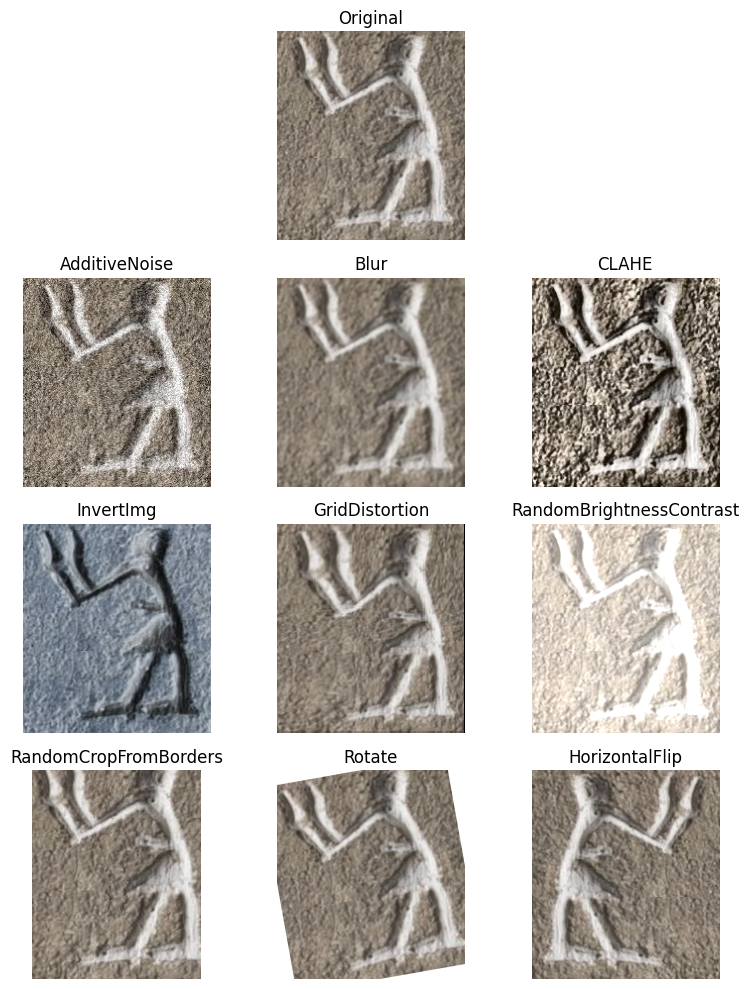

In [ ]:
# Lade das Beispielbild
image = cv2.imread('/content/drive/MyDrive/cropped_images/A30_image_14_1736527546722099.jpg')

# Definiere die Augmentation-Operationen
transforms = [
    A.AdditiveNoise(noise_type='gaussian', spatial_mode='shared', p=1.0),
    A.Blur(blur_limit=(1, 4), p=1.0),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(6, 6), p=1.0),
    A.InvertImg(p=1.0),
    A.GridDistortion(distort_limit=(-0.3, 0.3), p=1.0),
    A.RandomBrightnessContrast(brightness_limit=(0.3, 0.3), contrast_limit=(-0.3, 0.3), p=1.0),
    A.RandomCropFromBorders(crop_left=0.1, crop_right=0.1, crop_top=0.1, crop_bottom=0.1, p=1.0),
    A.Rotate(limit=(10, 10), border_mode=cv2.BORDER_CONSTANT, fill=255, crop_border=False, p=1.0),
    A.HorizontalFlip(p=1.0),
]

# Erstelle ein 4x3 Gitter für die Bilder
fig, axes = plt.subplots(4, 3, figsize=(8, 10))

# Zeige das Originalbild an Position 2
axes[0, 1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title('Original')
axes[0, 1].axis('off')

# Lösche Plot 1 und 3
fig.delaxes(axes[0, 0])  # Plot 1 löschen
fig.delaxes(axes[0, 2])  # Plot 3 löschen

# Zeige die augmentierten Bilder an den Positionen 4-12
for i, transform in enumerate(transforms):
    augmented_image = transform(image=image)['image']
    row = (i + 3) // 3  # Berechne die Zeile im Gitter
    col = (i + 3) % 3  # Berechne die Spalte im Gitter
    axes[row, col].imshow(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
    axes[row, col].set_title(type(transform).__name__)  # Verwende den Klassennamen als Titel
    axes[row, col].axis('off')

# Passe den Abstand zwischen den Subplots an
plt.subplots_adjust(hspace=0.2, wspace=0.1) # hspace und wspace hinzugefügt

plt.tight_layout()
plt.show()

In [ ]:
# Pfad zur ZIP-Datei
zip_file_path = '/content/drive/MyDrive/Datensatz_Final.zip'

# Zielordner
target_folder = '/content/Datensatz_Final'

# Erstelle den Zielordner, falls er nicht existiert
os.makedirs(target_folder, exist_ok=True)

# Entpacke die ZIP-Datei
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)

print(f"Datei '{zip_file_path}' wurde in '{target_folder}' entpackt.")

Datei '/content/drive/MyDrive/Datensatz_Final.zip' wurde in '/content/Datensatz_Final' entpackt.


Anwendung von Albumentations nach quellenspezifischen Regeln

In [ ]:
# Überprüfe, ob der Ordner existiert
if os.path.exists("/content/Datensatz_Augmented"):
    # Lösche den Ordner und seinen Inhalt
    shutil.rmtree("/content/Datensatz_Augmented")
    print("Ordner '/content/Datensatz_Augmented' gelöscht.")
else:
    print("Ordner '/content/Datensatz_Augmented' existiert nicht.")


# Definiere die quellenspezifischen Transformer
transformers = {
    "font": A.Compose([
        A.Blur(blur_limit=(1, 4), p=0.5),
        A.InvertImg(p=0.3),
        A.GridDistortion(distort_limit=(-0.3,0.3), p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.3,0.3),
            contrast_limit=(-0.3,0.3), p=1.0),
        A.RandomCropFromBorders(crop_left=0.05, crop_right=0.05, crop_top=0.05,
            crop_bottom=0.05, p=0.7),
        A.Rotate(limit=(-10,10), border_mode=cv2.BORDER_CONSTANT, fill=255, crop_border=False, p=0.3)
    ]),
    "Duque": A.Compose([
        A.AdditiveNoise(noise_type='gaussian', spatial_mode = 'shared', p=0.2),
        A.Blur(blur_limit=(1, 4), p=0.4),
        A.CLAHE(clip_limit=4.0, tile_grid_size = (6, 6), p=0.4),
        A.InvertImg(p=0.3),
        A.GridDistortion(distort_limit=(-0.3,0.3), p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.3,0.3),
            contrast_limit=(-0.3,0.3), p=1.0),
        A.RandomCropFromBorders(crop_left=0.05, crop_right=0.05, crop_top=0.05,
            crop_bottom=0.05, p=0.7),
        A.Rotate(limit=(-10,10), border_mode=cv2.BORDER_CONSTANT, fill=255, crop_border=False, p=0.3)
    ]),
    "Gemert": A.Compose([
        A.AdditiveNoise(noise_type='gaussian', spatial_mode = 'shared', p=0.2),
        A.Blur(blur_limit=(1, 4), p=0.4),
        A.CLAHE(clip_limit=4.0, tile_grid_size = (6, 6), p=0.4),
        A.InvertImg(p=0.3),
        A.GridDistortion(distort_limit=(-0.3,0.3), p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.3,0.3),
            contrast_limit=(-0.3,0.3), p=1.0),
        A.RandomCropFromBorders(crop_left=0.08, crop_right=0.08, crop_top=0.08,
            crop_bottom=0.08, p=0.7),
        A.Rotate(limit=(-10,10), border_mode=cv2.BORDER_CONSTANT, fill=255, crop_border=False, p=0.3)
    ]),
    "Manuell": A.Compose([
        A.AdditiveNoise(noise_type='gaussian', spatial_mode = 'shared', p=0.2),
        A.Blur(blur_limit=(1, 4), p=0.4),
        A.CLAHE(clip_limit=4.0, tile_grid_size = (6, 6), p=0.4),
        A.InvertImg(p=0.3),
        A.GridDistortion(distort_limit=(-0.3,0.3), p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.3,0.3),
            contrast_limit=(-0.3,0.3), p=1.0),
        A.RandomCropFromBorders(crop_left=0.05, crop_right=0.05, crop_top=0.05,
            crop_bottom=0.05, p=0.7),
        A.Rotate(limit=(-10,10), border_mode=cv2.BORDER_CONSTANT, fill=255, crop_border=False, p=0.3)
    ]),
    "Segment_groß": A.Compose([
        A.AdditiveNoise(noise_type='gaussian', spatial_mode = 'shared', p=0.2),
        A.Blur(blur_limit=(1, 4), p=0.4),
        A.CLAHE(clip_limit=4.0, tile_grid_size = (6, 6), p=0.4),
        A.InvertImg(p=0.3),
        A.GridDistortion(distort_limit=(-0.3,0.3), p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.3,0.3),
            contrast_limit=(-0.3,0.3), p=1.0),
        A.RandomCropFromBorders(crop_left=0.08, crop_right=0.08, crop_top=0.08,
            crop_bottom=0.08, p=0.7),
        A.Rotate(limit=(-10,10), border_mode=cv2.BORDER_CONSTANT, fill=255, crop_border=False, p=0.3)
    ]),
    "Segment_klein": A.Compose([
        A.CLAHE(clip_limit=4.0, tile_grid_size = (2, 2), p=0.4),
        A.InvertImg(p=0.3),
        A.GridDistortion(distort_limit=(-0.3,0.3), p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.3,0.3),
            contrast_limit=(-0.3,0.3), p=1.0),
        A.RandomCropFromBorders(crop_left=0.08, crop_right=0.08, crop_top=0.08,
            crop_bottom=0.08, p=0.7),
        A.Rotate(limit=(-10,10), border_mode=cv2.BORDER_CONSTANT, fill=255, crop_border=False, p=0.3)
    ])
}

# Erstelle den Zielordner, falls er nicht existiert
os.makedirs("/content/Datensatz_Augmented", exist_ok=True)

# Kopiere und transformiere die Bilder
for filename in os.listdir("/content/Datensatz_Final"):
#filename = "A1_Segment_image_15_398.png"
    if filename.endswith(".png"):
        source_path = os.path.join("/content/Datensatz_Final", filename)

        # Kopiere zuerst das Bild ohne Transformation
        shutil.copy(source_path, "/content/Datensatz_Augmented")

        parts = filename.split("_")
        source = parts[1]  # Extrahiere die Quelle aus dem Dateinamen
        klassenlabel = parts[0]  # Extrahiere das Klassenlabel aus dem Dateinamen

        # Anzahl der Kopien basierend auf Quelle und Klassenzählung bestimmen
        anzahl_kopien = 0
        if source == "font":
            anzahl_kopien = 29
        if source in ["Duque", "Gemert", "Segment"]:
            anzahl_in_df = df.loc[df['Klassenlabel'] == klassenlabel, source].values[0]
            if anzahl_in_df < 30:
                anzahl_kopien = 5
            elif anzahl_in_df < 100:
                anzahl_kopien = 3
        if source == "Manuell":
            anzahl_kopien = 19

        # Wende den quellenspezifischen Transformer an und erstelle Kopien
        if source in transformers or source == 'Segment':
          if source == 'Segment':

              # Bild laden und maximale Kantenlänge ermitteln
              image = cv2.imread(source_path)
              hoehe, breite = image.shape[:2]
              max_kante = max(hoehe, breite)

              if max_kante < 50:
                for i in range(anzahl_kopien):
                  transformed = transformers['Segment_klein'](image=image)["image"]
                  target_path = os.path.join("/content/Datensatz_Augmented", f"{filename[:-4]}_aug_{i}.png")
                  cv2.imwrite(target_path, transformed)
              else:
                for i in range(anzahl_kopien):
                  transformed = transformers['Segment_groß'](image=image)["image"]
                  target_path = os.path.join("/content/Datensatz_Augmented", f"{filename[:-4]}_aug_{i}.png")
                  cv2.imwrite(target_path, transformed)

          else:
              image = cv2.imread(source_path)
              for i in range(anzahl_kopien):
                  transformed = transformers[str(source)](image=image)["image"]
                  target_path = os.path.join("/content/Datensatz_Augmented", f"{filename[:-4]}_aug_{i}.png")
                  cv2.imwrite(target_path, transformed)


# Erstelle horizontal geflippte Kopien aller Bilder im Zielordner
for filename in os.listdir("/content/Datensatz_Augmented"):
    if filename.endswith(".png"):
        image_path = os.path.join("/content/Datensatz_Augmented", filename)
        image = cv2.imread(image_path)
        flipped_image = cv2.flip(image, 1)  # 1 für horizontales Flippen
        flipped_filename = filename[:-4] + "_flipped.png"
        flipped_path = os.path.join("/content/Datensatz_Augmented", flipped_filename)
        cv2.imwrite(flipped_path, flipped_image)

print("Augmentierung abgeschlossen.")

# 9 min

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/albumentations/augmentations/blur/functional.py:147: UserWarning: blur_limit: Invalid kernel size range (1, 4). Values less than 3 are not allowed. Range automatically adjusted to (3, 4).
  result = _ensure_min_value(result, min_value, info.field_name)
/usr/local/lib/python3.11/dist-packages/albumentations/augmentations/blur/functional.py:148: UserWarning: blur_limit: Non-zero kernel sizes must be odd. Range (3, 4) automatically adjusted to (3, 5).
  result = _ensure_odd_values(result, info.field_name)


Ordner '/content/Datensatz_Augmented' existiert nicht.
Augmentierung abgeschlossen.


In [ ]:
def zip_folder(folder_path, output_filename):
  """
  Komprimiert einen Ordner in ein Zip-Archiv.

  Args:
    folder_path: Der Pfad zum Ordner, der komprimiert werden soll.
    output_filename: Der Name der komprimierten Datei.
  """

  with zipfile.ZipFile(output_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(folder_path):
      for file in files:
        file_path = os.path.join(root, file)
        zipf.write(file_path, os.path.relpath(file_path, folder_path))

# Beispielaufruf:
folder_path = "/content/Datensatz_Augmented" # Pfad zum Ordner, der komprimiert werden soll
output_filename = "Datensatz_Augmented.zip" # Name der komprimierten Datei
zip_folder(folder_path, output_filename)

In [ ]:
def get_folder_size(folder_path):
    """
    Ermittelt die Größe eines Ordners in MB.

    Args:
        folder_path: Der Pfad zum Ordner.

    Returns:
        Die Größe des Ordners in MB.
    """
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)

    return total_size / (1024 * 1024)  # Größe in MB


# Pfad zum Ordner
folder_path = "/content/Datensatz_Augmented"

# Anzahl der Elemente im Ordner
num_elements = len(os.listdir(folder_path))

# Gesamtgröße des Ordners in MB
folder_size_mb = get_folder_size(folder_path)

# Ausgabe der Ergebnisse
print(f"Der Ordner '{folder_path}' enthält {num_elements} Elemente.")
print(f"Größe des Ordners: {folder_size_mb:.2f} MB")

Der Ordner '/content/Datensatz_Augmented' enthält 252344 Elemente.
Größe des Ordners: 4331.86 MB


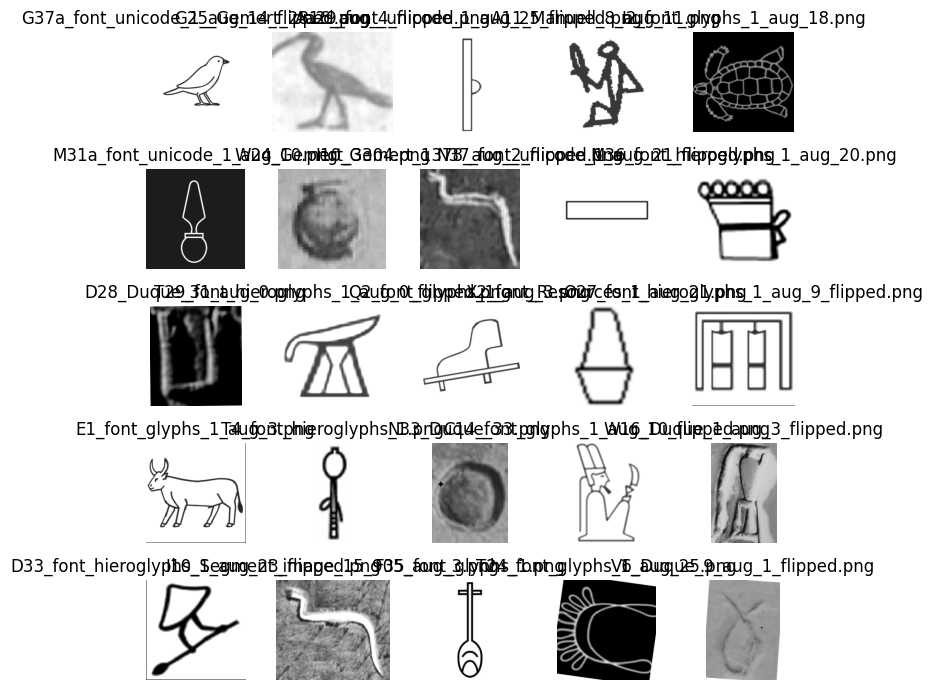

In [ ]:
# Pfad zum Ordner mit den Bildern
ordner_pfad = "/content/Datensatz_Augmented"

# Liste aller Bilddateien im Ordner erstellen
bilddateien = [f for f in os.listdir(ordner_pfad) if f.endswith(('.png', '.jpg', '.jpeg'))]

# 9 zufällige Bilder auswählen
ausgewaehlte_bilder = random.sample(bilddateien, min(25, len(bilddateien)))

# 3x3 Gitter erstellen
fig, axes = plt.subplots(5, 5, figsize=(7,7))

# Bilder im Gitter anzeigen
for i, bilddatei in enumerate(ausgewaehlte_bilder):
    bild_pfad = os.path.join(ordner_pfad, bilddatei)
    bild = cv2.imread(bild_pfad)

    # Elementnamen extrahieren
    elementname = bilddatei

    # Bild im Subplot anzeigen
    zeile = i // 5
    spalte = i % 5
    axes[zeile, spalte].imshow(cv2.cvtColor(bild, cv2.COLOR_BGR2RGB))
    axes[zeile, spalte].set_title(elementname)
    axes[zeile, spalte].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import os
from collections import defaultdict
import pandas as pd

def zaehle_bilder_in_ordnern(ordner_pfad):
    """Zählt Bilder in verschiedenen Ordnern und gibt die Ergebnisse in einem DataFrame zurück.

    Args:
        ordner_pfad: Der Pfad zum Ordner, der die Bilder enthält.

    Returns:
        Ein pandas DataFrame mit den Klassenlabels als Index und den Ordnernamen als Spalten.
    """

    anzahl_bilder_pro_klasse = defaultdict(lambda: defaultdict(int))

    for dateiname in os.listdir(ordner_pfad):
        if dateiname.endswith(('.png', '.PNG', '.jpg', '.jpeg')):
            teile = dateiname.split('_')
            klassenlabel = teile[0]
            quelle = teile[1]  # Extrahiere die Quelle aus dem Dateinamen
            anzahl_bilder_pro_klasse[klassenlabel][quelle] += 1

    # DataFrame erstellen
    df = pd.DataFrame(anzahl_bilder_pro_klasse).T.fillna(0).astype(int)
    df.index.name = 'Klassenlabel'

    # Klassenlabels als erste Spalte setzen
    df = df.reset_index()

    return df

# Beispielaufruf
ordner_pfad = '/content/Datensatz_Augmented'
df_aug = zaehle_bilder_in_ordnern(ordner_pfad)
print(df_aug)

# DataFrame als CSV exportieren
df_aug.to_csv('klassen_anzahlen_augmented.csv', index=False)

    Klassenlabel  Gemert  font  Duque  Segment  Manuell
0            D36     472   160    652      328        0
1            D21     732   160   1428      500        0
2            S35       0   160      0        0        0
3             E3       0   160      0        0        0
4            N36      24   160    160       48       40
..           ...     ...   ...    ...      ...      ...
962          D66       0   120      0        0        0
963         O10b       0   120      0        0        0
964          S26       0   160      0        0        0
965         O19a       0    80      0        0        0
966         N34a       0    80      0        0        0

[967 rows x 6 columns]


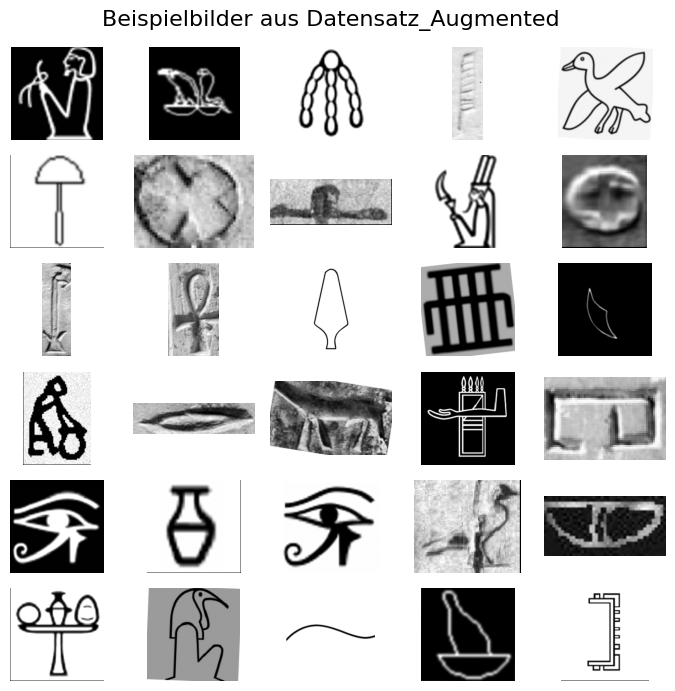

In [ ]:
# Beispielgitter ausgeben
zielordner = '/content/Datensatz_Augmented'

bilddateien = [f for f in os.listdir(zielordner) if f.endswith('.png')]
ausgewaehlte_bilder = random.sample(bilddateien, min(30, len(bilddateien)))

fig, axes = plt.subplots(6, 5, figsize=(7,7))
fig.suptitle("Beispielbilder aus Datensatz_Augmented", fontsize=16)

for i, bilddatei in enumerate(ausgewaehlte_bilder):
    bild_pfad = os.path.join(zielordner, bilddatei)
    bild = cv2.imread(bild_pfad, cv2.IMREAD_GRAYSCALE)

    zeile = i // 5
    spalte = i % 5
    axes[zeile, spalte].imshow(bild, cmap='gray')
    axes[zeile, spalte].axis('off')
    #axes[zeile, spalte].set_title(bilddatei, fontsize=6) # Dateiname als Titel mit Schriftgröße 8

plt.tight_layout()
plt.show()

# Vorbereitung für YOLO

In [ ]:
import zipfile
import os
import random
from sklearn.model_selection import train_test_split
import shutil
from collections import defaultdict

Aufteilung in Trainings-, Validierungs- und Testdaten

In [ ]:
# Pfad zur ZIP-Datei
zip_file_path = '/content/drive/MyDrive/Datensatz_Augmented.zip'

# Zielordner
target_folder = '/content/Datensatz_Augmented'

# Erstelle den Zielordner, falls er nicht existiert
os.makedirs(target_folder, exist_ok=True)

# Entpacke die ZIP-Datei
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)

print(f"Datei '{zip_file_path}' wurde in '{target_folder}' entpackt.")

Datei '/content/drive/MyDrive/Datensatz_Augmented.zip' wurde in '/content/Datensatz_Augmented' entpackt.


In [ ]:
# Pfad zum Datensatz
data_dir = '/content/Datensatz_Augmented'

# Leere Listen für Bildpfade und Labels
image_paths = []
labels = []

# Durchlaufe alle Dateien im Datensatzordner
for filename in os.listdir(data_dir):
    # Überprüfe, ob es sich um eine Bilddatei handelt
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        # Extrahiere die Klasse aus dem Dateinamen
        label = filename.split('_')[0]

        # Überprüfe, ob das Label in der Liste gardinercodes_liste vorkommt
        if label in gardiner_values_list:
            # Füge den Bildpfad zur Liste hinzu
            image_paths.append(os.path.join(data_dir, filename))
            # Füge das Label zur Label-Liste hinzu
            labels.append(label)

# Teile die Daten in Trainings- und Testdaten auf
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.1, random_state=42  # 90:10 Aufteilung, zufälliger Seed für Reproduzierbarkeit
)

# Teile die Trainingsdaten in Trainings- und Validierungsdaten auf
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.111, random_state=42  # 80:10:10 Aufteilung, zufälliger Seed für Reproduzierbarkeit
)

# Gebe die Anzahl der Trainings-, Validierungs- und Testdaten aus
print(f"Anzahl Trainingsdaten: {len(train_paths)}")
print(f"Anzahl Validierungsdaten: {len(val_paths)}")
print(f"Anzahl Testdaten: {len(test_paths)}")

Anzahl Trainingsdaten: 252772
Anzahl Validierungsdaten: 31561
Anzahl Testdaten: 31593


In [ ]:
def prepare_classification_data(image_paths, labels, output_dir, data_type='train'):
    """
    Prepares data for classification by organizing it into class-specific folders.
    Assumes data is already split into train/val/test.
    """
    # Create output directory
    os.makedirs(os.path.join(output_dir, data_type), exist_ok=True)

    # Group image paths by label
    images_by_label = defaultdict(list)
    for img_path, label in zip(image_paths, labels):
        images_by_label[label].append(img_path)

    # Copy images to class folders
    for label, img_paths in images_by_label.items():
        # Create class folder
        os.makedirs(os.path.join(output_dir, data_type, label), exist_ok=True)

        # Copy images to folder
        for img_path in img_paths:
            shutil.copy(img_path, os.path.join(output_dir, data_type, label, os.path.basename(img_path)))

# Example usage:
prepare_classification_data(image_paths=train_paths, labels=train_labels, output_dir='/content/classification_dataset', data_type='train')
prepare_classification_data(image_paths=val_paths, labels=val_labels, output_dir='/content/classification_dataset', data_type='val')
prepare_classification_data(image_paths=test_paths, labels=test_labels, output_dir='/content/classification_dataset', data_type='test')

# YOLO-Training

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.2/922.2 kB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
from ultralytics import YOLO

model = YOLO('yolo11m-cls.pt')  # Lade das vortrainierte YOLOv11-Klassifizierungsmodell (kleinste Variante)
model.model.nc = len(gardiner_values_list)  # Setze die Anzahl der Klassen auf 1000
model.model.names = gardiner_values_list  # Ersetze your_class_names mit einer Liste deiner Klassennamen

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 22.4M/22.4M [00:00<00:00, 42.6MB/s]


In [ ]:
from ultralytics import YOLO

model = YOLO('/content/drive/MyDrive/YOLO11m_10_128_01.pt')  # Lade das vortrainierte YOLOv11-Klassifizierungsmodell (kleinste Variante)
model.model.nc = len(gardiner_values_list)  # Setze die Anzahl der Klassen auf 1000
model.model.names = gardiner_values_list  # Ersetze your_class_names mit einer Liste deiner Klassennamen

In [ ]:
model.train(data='/content/classification_dataset',
            epochs=5,
            batch=128,
            imgsz=224,
            optimizer='AdamW',
            lr0=0.0001,  #Standard ist 0.01, bei Fortführung auf 1/10 reduzieren
            lrf=1.0,
            #cos_lr = True,
            cache=True,
            weight_decay=0.02, #Standard ist 0.0005
            #dropout=0.3, #Standard ist 0.0
            #save_period=1,
            #resume=True,   # Für eine Fortsetzung des Trainings
            warmup_epochs=0, # Für eine Fortführung des Trainings
            device=0)  #GPU
#Ca. 3:20 pro Epoche
#Auto-Modus für 60% GPU Speicherauslastung (batch=-1)

New https://pypi.org/project/ultralytics/8.3.85 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.84 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=classify, mode=train, model=/content/drive/MyDrive/YOLO11m_10_128_01.pt, data=/content/classification_dataset, epochs=5, time=None, patience=100, batch=128, imgsz=224, save=True, save_period=-1, cache=True, device=0, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fals

train: Scanning /content/classification_dataset/train... 252725 images, 47 corrupt: 100%|██████████| 252725/252725 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/classification_dataset/train/D21/D21_Segment_image_17_120.png: ignoring corrupt image/label: image size (9, 32) <10 pixels
train: WARNING ⚠️ /content/classification_dataset/train/D21/D21_Segment_image_17_120_flipped.png: ignoring corrupt image/label: image size (9, 32) <10 pixels
train: WARNING ⚠️ /content/classification_dataset/train/D36/D36_Segment_image_17_2128.png: ignoring corrupt image/label: image size (7, 31) <10 pixels
train: WARNING ⚠️ /content/classification_dataset/train/D36/D36_Segment_image_17_2128_aug_0.png: ignoring corrupt image/label: image size (7, 31) <10 pixels
train: WARNING ⚠️ /content/classification_dataset/train/D36/D36_Segment_image_17_2128_aug_0_flipped.png: ignoring corrupt image/label: image size (7, 31) <10 pixels
train: WARNING ⚠️ /content/classification_dataset/train/D36/D36_Segment_image_17_2128_aug_1.png: ignoring corrupt image/label: image size (7, 31) <10 pixels
train: WARNING ⚠️ /content/classification_dataset/train/D36/D3

WARNING ⚠️ Classification `cache_ram` training has known memory leak in https://github.com/ultralytics/ultralytics/issues/9824, setting `cache_ram=False`.


val: Scanning /content/classification_dataset/val... 31558 images, 3 corrupt: 100%|██████████| 31558/31558 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/classification_dataset/val/N35/N35_Segment_image_17_1094.png: ignoring corrupt image/label: image size (8, 31) <10 pixels
val: WARNING ⚠️ /content/classification_dataset/val/O34/O34_Segment_image_17_2101_aug_2.png: ignoring corrupt image/label: image size (8, 31) <10 pixels
val: WARNING ⚠️ /content/classification_dataset/val/Z3/Z3_Segment_image_17_1946_aug_2_flipped.png: ignoring corrupt image/label: image size (28, 7) <10 pixels


optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 49 weight(decay=0.0), 50 weight(decay=0.04), 50 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs/classify/train4
Starting training for 5 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 124/124 [00:16<00:00,  7.49it/s]


                   all      0.961      0.997

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 124/124 [00:16<00:00,  7.50it/s]


                   all      0.961      0.997

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 124/124 [00:16<00:00,  7.49it/s]


                   all      0.962      0.997

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 124/124 [00:16<00:00,  7.49it/s]


                   all      0.963      0.997

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 124/124 [00:16<00:00,  7.43it/s]


                   all      0.964      0.997

5 epochs completed in 0.607 hours.
Optimizer stripped from runs/classify/train4/weights/last.pt, 23.4MB
Optimizer stripped from runs/classify/train4/weights/best.pt, 23.4MB

Validating runs/classify/train4/weights/best.pt...
Ultralytics 8.3.84 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11m-cls summary (fused): 57 layers, 11,580,359 parameters, 0 gradients, 40.3 GFLOPs
train: /content/classification_dataset/train... found 252772 images in 967 classes ✅ 
val: /content/classification_dataset/val... found 31561 images in 967 classes ✅ 
test: /content/classification_dataset/test... found 31593 images in 967 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 124/124 [00:15<00:00,  8.26it/s]


                   all      0.964      0.997
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train4


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b0f61d48c50>
curves: []
curves_results: []
fitness: 0.9807497262954712
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9642879962921143, 'metrics/accuracy_top5': 0.9972114562988281, 'fitness': 0.9807497262954712}
save_dir: PosixPath('runs/classify/train4')
speed: {'preprocess': 0.0564841113509549, 'inference': 0.4037069688828696, 'loss': 6.0032035869802426e-05, 'postprocess': 0.00014092600933326345}
task: 'classify'
top1: 0.9642879962921143
top5: 0.9972114562988281

Test

In [ ]:
model.save('YOLO11m_15_128_01_0001.pt')

In [ ]:
# Before validation, reset model.names if it was modified during training
#model.model.names = gardiner_values_list

results = model.val(data='/content/classification_dataset',   # Pfad zu deinem Testdatensatz
                    imgsz = 224,
                    batch = 128,
                    device = 0,
                    split='test')

Ultralytics 8.3.84 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11m-cls summary (fused): 57 layers, 11,580,359 parameters, 0 gradients, 40.3 GFLOPs
train: /content/classification_dataset/train... found 252772 images in 967 classes ✅ 
val: /content/classification_dataset/val... found 31561 images in 967 classes ✅ 
test: /content/classification_dataset/test... found 31593 images in 967 classes ✅ 
WARNING ⚠️ Classification `cache_ram` training has known memory leak in https://github.com/ultralytics/ultralytics/issues/9824, setting `cache_ram=False`.


test: Scanning /content/classification_dataset/test... 31587 images, 6 corrupt: 100%|██████████| 31587/31587 [00:00<?, ?it/s]

test: WARNING ⚠️ /content/classification_dataset/test/D36/D36_Segment_image_17_2128_aug_1_flipped.png: ignoring corrupt image/label: image size (7, 31) <10 pixels
test: WARNING ⚠️ /content/classification_dataset/test/D53/D53_Segment_image_17_101_aug_4_flipped.png: ignoring corrupt image/label: image size (9, 35) <10 pixels
test: WARNING ⚠️ /content/classification_dataset/test/N35/N35_Segment_image_17_1407_flipped.png: ignoring corrupt image/label: image size (8, 33) <10 pixels
test: WARNING ⚠️ /content/classification_dataset/test/O34/O34_Segment_image_17_2105_aug_0_flipped.png: ignoring corrupt image/label: image size (7, 30) <10 pixels
test: WARNING ⚠️ /content/classification_dataset/test/O34/O34_Segment_image_17_2105_aug_2_flipped.png: ignoring corrupt image/label: image size (7, 29) <10 pixels
test: WARNING ⚠️ /content/classification_dataset/test/Z3/Z3_Segment_image_17_1946_aug_0.png: ignoring corrupt image/label: image size (30, 8) <10 pixels



               classes   top1_acc   top5_acc: 100%|██████████| 247/247 [00:25<00:00,  9.52it/s]


                   all      0.964      0.998
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train42
Ultralytics 8.3.84 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
train: /content/classification_dataset/train... found 252772 images in 967 classes ✅ 
val: /content/classification_dataset/val... found 31561 images in 967 classes ✅ 
test: /content/classification_dataset/test... found 31593 images in 967 classes ✅ 
WARNING ⚠️ Classification `cache_ram` training has known memory leak in https://github.com/ultralytics/ultralytics/issues/9824, setting `cache_ram=False`.


test: Scanning /content/classification_dataset/test... 31587 images, 6 corrupt: 100%|██████████| 31587/31587 [00:00<?, ?it/s]

test: WARNING ⚠️ /content/classification_dataset/test/D36/D36_Segment_image_17_2128_aug_1_flipped.png: ignoring corrupt image/label: image size (7, 31) <10 pixels
test: WARNING ⚠️ /content/classification_dataset/test/D53/D53_Segment_image_17_101_aug_4_flipped.png: ignoring corrupt image/label: image size (9, 35) <10 pixels
test: WARNING ⚠️ /content/classification_dataset/test/N35/N35_Segment_image_17_1407_flipped.png: ignoring corrupt image/label: image size (8, 33) <10 pixels
test: WARNING ⚠️ /content/classification_dataset/test/O34/O34_Segment_image_17_2105_aug_0_flipped.png: ignoring corrupt image/label: image size (7, 30) <10 pixels
test: WARNING ⚠️ /content/classification_dataset/test/O34/O34_Segment_image_17_2105_aug_2_flipped.png: ignoring corrupt image/label: image size (7, 29) <10 pixels
test: WARNING ⚠️ /content/classification_dataset/test/Z3/Z3_Segment_image_17_1946_aug_0.png: ignoring corrupt image/label: image size (30, 8) <10 pixels



               classes   top1_acc   top5_acc: 100%|██████████| 247/247 [00:26<00:00,  9.49it/s]


                   all      0.964      0.998
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train43


In [ ]:
import pandas as pd
import numpy as np

# Extrahiere die Matrixdaten
cm = results.confusion_matrix.matrix

# Wandle die Matrix in ein Numpy-Array um
cm_array = np.array(cm)

# Definiere eine Funktion, um Gardiner-Codes in Klarnamen zu konvertieren
def get_klarname(gardiner_code):
  for gardiner_id, gardiner_value in gardiner_dict.items():
      if gardiner_value == gardiner_code+1:
          return str(gardiner_id)  # Anpassen, falls die Gardiner-IDs nicht bei 1 beginnen
  return gardiner_code  # Falls kein Klarname gefunden wird, gib den Gardiner-Code zurück

# Ersetze model.names durch die Klarnamen
klarnamen = [get_klarname(code) for code in model.names]

# Erstelle den DataFrame
df_cm = pd.DataFrame(cm_array, index=klarnamen, columns=klarnamen)

display(df_cm)
# Exportiere den DataFrame als CSV
df_cm.to_csv('confusion_matrix_YOLO11m_15_01_0001.csv', encoding='utf-8')

,A1,A2,A3,A4,A5,A5a,A6,A6a,A6b,A7,...,Aa23,Aa24,Aa25,Aa26,Aa27,Aa28,Aa29,Aa30,Aa31,Aa32
A1,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A4,0.0,0.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A5,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Aa28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0
Aa29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0
Aa30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0,0.0,0.0
Aa31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0


,A1,A2,A3,A4,A5,A5a,A6,A6a,A6b,A7,...,Aa23,Aa24,Aa25,Aa26,Aa27,Aa28,Aa29,Aa30,Aa31,Aa32
A1,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A3,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A4,0.0,0.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A5,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Aa28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0
Aa29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0
Aa30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0,0.0,0.0
Aa31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0


#Analyse Klassifikator

In [ ]:
import pandas as pd

# CSV-Datei einlesen
df = pd.read_csv('/content/drive/MyDrive/YOLO Modelle/confusion_matrix_Klassifikator.csv', sep=';')

# Gewünschte Spalten auswählen und neuen DataFrame erstellen
df_results = df[['Code', 'GenauigkeitKlasse', 'FalschVorhersagenGleicheGruppe', 'FalschVorhersagenAndereGruppe']]

# Neuen DataFrame anzeigen
display(df_results)

,Code,GenauigkeitKlasse,FalschVorhersagenGleicheGruppe,FalschVorhersagenAndereGruppe
0,A1,1,#DIV/0!,#DIV/0!
1,A2,1,#DIV/0!,#DIV/0!
2,A3,1,#DIV/0!,#DIV/0!
3,A4,1,#DIV/0!,#DIV/0!
4,A5,1,#DIV/0!,#DIV/0!
...,...,...,...,...
962,Aa28,1,#DIV/0!,#DIV/0!
963,Aa29,1,#DIV/0!,#DIV/0!
964,Aa30,"0,986842105",0,1
965,Aa31,"0,666666667",0,1


In [ ]:
# CSV-Datei einlesen
df = pd.read_csv('/content/drive/MyDrive/Mathestudium/Data Science MSc/Masterarbeit/Datensätze/klassen_anzahlen_Klassifikator.csv', sep=';')

# Alternativ, falls die Spaltennamen bekannt sind:
df_counts = df[['Rang', 'Code', 'Final']]

# Neuen DataFrame anzeigen
display(df_counts)

,Rang,Code,Final
0,1,N35,2598
1,2,M17,2144
2,3,X1,1974
3,4,D21,1570
4,5,I9,1930
...,...,...,...
962,963,R28,120
963,964,A65,120
964,965,A69,120
965,966,O33a,120


In [ ]:
# Left Join durchführen und nur die Spalte 'Code' aus new_df behalten
merged_df = pd.merge(df_results, df_counts[['Rang','Code','Final']], on='Code', how='left')

# Spalten in der gewünschten Reihenfolge sortieren
desired_order = ['Code', 'Rang', 'Final', 'GenauigkeitKlasse', 'FalschVorhersagenGleicheGruppe', 'FalschVorhersagenAndereGruppe']
merged_df = merged_df[desired_order]

merged_df.to_csv('merged_data.csv', index=False)

# Finalen DataFrame anzeigen
display(merged_df)

,Code,Rang,Final,GenauigkeitKlasse,FalschVorhersagenGleicheGruppe,FalschVorhersagenAndereGruppe
0,A1,18,812,1,#DIV/0!,#DIV/0!
1,A2,64,668,1,#DIV/0!,#DIV/0!
2,A3,300,304,1,#DIV/0!,#DIV/0!
3,A4,320,276,1,#DIV/0!,#DIV/0!
4,A5,289,332,1,#DIV/0!,#DIV/0!
...,...,...,...,...,...,...
962,Aa28,278,268,1,#DIV/0!,#DIV/0!
963,Aa29,753,192,1,#DIV/0!,#DIV/0!
964,Aa30,748,220,"0,986842105",0,1
965,Aa31,743,220,"0,666666667",0,1
